In [1]:
import os
import scanpy as sc
from os.path import join

import sys
sys.path.insert(0, '../..')

from spamosaic.framework import SpaMosaic

In [2]:
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # for CuBLAS operation and you have CUDA >= 10.2
import spamosaic.utils as utls
from spamosaic.preprocessing import RNA_preprocess, ADT_preprocess, Epigenome_preprocess

In [3]:
data_dir = '/home/xuhua/xuhua_disco/gitrepo/BridgeNorm/SpaMosaic-release/data/imputation/Mouse_postnatal_brain'

ad1_rna = sc.read_h5ad(join(data_dir, 'Slice1/s1_adata_rna.h5ad'))
ad1_atac = sc.read_h5ad(join(data_dir, 'Slice1/s1_adata_atac.h5ad'))
# ad2_rna = sc.read_h5ad(join(data_dir, 'Slice2/s2_adata_rna.h5ad'))
# ad2_atac = sc.read_h5ad(join(data_dir, 'Slice2/s2_adata_atac.h5ad'))
# ad3_rna = sc.read_h5ad(join(data_dir, 'Slice3/s3_adata_rna.h5ad'))
# ad3_atac = sc.read_h5ad(join(data_dir, 'Slice3/s3_adata_atac.h5ad'))

### preprocessing

In [4]:
input_dict = {
    'rna':  [ad1_rna, ],
    'atac': [ad1_atac,]
}

input_key = 'dimred_bc'

In [5]:
RNA_preprocess(input_dict['rna'], batch_corr=False, n_hvg=5000, batch_key='src', key=input_key)
Epigenome_preprocess(input_dict['atac'], batch_corr=False, n_peak=50000, batch_key='src', key=input_key)

### training

In [6]:
model = SpaMosaic(
    modBatch_dict=input_dict, input_key=input_key,
    batch_key='src', intra_knn=10, inter_knn=10, w_g=0.8, 
    seed=1234, 
    device='cuda:0'
)

model.train(net='wlgcn', lr=0.01, T=0.01, n_epochs=100)

batch0: ['rna', 'atac']
------Calculating spatial graph...
The graph contains 23720 edges, 2372 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 23720 edges, 2372 cells.
10.0000 neighbors per cell on average.
Number of mnn pairs for rna:0
Number of mnn pairs for atac:0


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 29.09it/s]


In [7]:
ad_embs = model.infer_emb(input_dict, emb_key='emb', final_latent_key='merged_emb')
ad_mosaic = sc.concat(ad_embs)
ad_mosaic = utls.get_umap(ad_mosaic, use_reps=['merged_emb'])

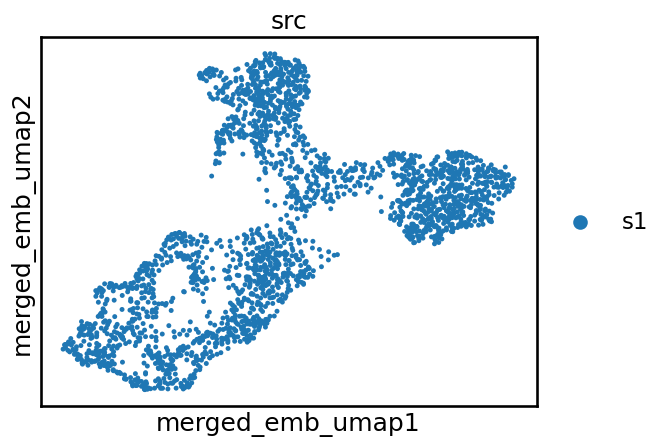

In [8]:
utls.plot_basis(ad_mosaic, basis='merged_emb_umap', color=['src'])

### clustering

In [9]:
utls.clustering(ad_mosaic, n_cluster=6, used_obsm='merged_emb', algo='mclust', key='mclust')
utls.split_adata_ob(ad_embs, ad_mosaic, 'obs', 'mclust')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |                                                                      |   0%

  |======================================================================| 100%


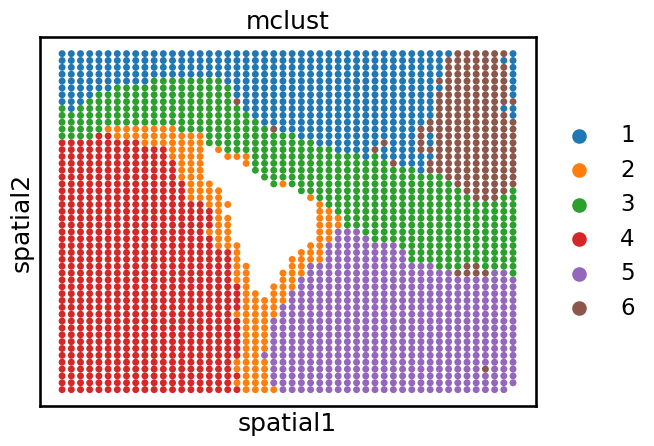

In [10]:
for ad in ad_embs:
    utls.plot_basis(ad, 'spatial', 'mclust', s=100)